# Colab runtime

The recommended runtime to use for fitting the gpSLDS is a NVIDIA A100 GPU. On Colab, you can select this runtime by clicking Runtime -> Change runtime type -> A100 GPU.

If an A100 is not available, other GPUs may be selected using the steps above. In that case you may need to change the batch size to fit the model using stochastic vEM in order to avoid out-of-memory errors.

# Imports

In [1]:
# general imports
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import pickle
import matplotlib.pyplot as plt

import numpy as np

import ssm

In [2]:
!git clone https://github.com/lindermanlab/gpslds.git

fatal: destination path 'gpslds' already exists and is not an empty directory.


In [3]:
!pip install --quiet wandb
!pip install --quiet git+https://github.com/lindermanlab/ssm.git@master#egg=ssm

In [4]:
# import functions from gpslds codebase
import sys

sys.path.append("/home/ynffsy/Desktop/andersen_lab/dependencies/gpslds/data")
from generate_synthetic_data import generate_synthetic_dynamics

sys.path.append("/home/ynffsy/Desktop/andersen_lab/dependencies/gpslds/gpslds")
from kernels import Linear, SSL
from transition import SparseGP
from likelihoods import PoissonProcess, Gaussian
from initialization import initialize_zs, initialize_affine_params
from quadrature import GaussHermiteQuadrature
from em import fit_variational_em
from utils import get_transformation_for_latents, get_posterior_f_mean, get_posterior_f_var, get_most_likely_state, get_learned_partition, bin_sparse_data

# Plotting helper functions

Helper functions for plotting the synthetic data.

In [5]:
def plot_dynamics(dynamics_fn, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x, y = jnp.meshgrid(
        jnp.linspace(*xlim, n_xpts),
        jnp.linspace(*ylim, n_ypts)
    )
    input_locs = jnp.column_stack([x.ravel(), y.ravel()])

    fs = vmap(dynamics_fn)(input_locs)
    ax.quiver(input_locs[:,0], input_locs[:,1], fs[:,0], fs[:,1], angles='xy')
    ax.set_title("true dynamics", fontsize=fontsize)
    ax.set_xlabel(r"$x_1$", fontsize=fontsize)
    ax.set_ylabel(r"$x_2$", fontsize=fontsize)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax

def plot_dynamics_and_latents(dynamics_fn, latents, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12, alpha=0.5):
    assert latents.shape[-1] == 2
    ax = plot_dynamics(dynamics_fn, xlim=xlim, ylim=ylim, n_xpts=n_xpts, n_ypts=n_ypts, ax=ax, figsize=figsize, fontsize=fontsize)
    for latent in latents:
        ax.plot(latent[:,0], latent[:,1], alpha=alpha)
    ax.set_title("true dynamics & latents")
    return ax

def plot_latents_over_time(t_max, latents_mean, latents_cov=None, ax=None, figsize=(4, 3), fontsize=12, color='red', alpha=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    t_grid = jnp.linspace(0, t_max, latents_mean.shape[0])
    latent_dim = latents_mean.shape[-1]

    for i in range(latent_dim):
        ax.plot(t_grid, latents_mean[:,i], color=color)

    if latents_cov is not None:
        for i in range(latent_dim):
            ax.fill_between(t_grid, latents_mean[:,i]+2*jnp.sqrt(latents_cov[:,i,i]),
                    latents_mean[:,i]-2*jnp.sqrt(latents_cov[:,i,i]), facecolor=color, alpha=alpha)

    ax.set_xlabel("time (s)", fontsize=fontsize)
    ax.set_ylabel(r"$x_1(t), x_2(t)$", fontsize=fontsize)
    return ax

# Load in dataset and pLDS emissions

In [6]:
# load in data and initial emissions parameters
data_path = "/home/ynffsy/Desktop/andersen_lab/dependencies/gpslds/data/synthetic_data.pkl"
with open(data_path, 'rb') as f:
    dataset = pickle.load(f)
dt, all_xs, all_spikes, C, d = dataset

# emissions_path = "/home/ynffsy/Desktop/andersen_lab/dependencies/gpslds/data/synthetic_plds_emissions.pkl"
# with open(emissions_path, 'rb') as f:
#     elbos, q, C_plds, d_plds = pickle.load(f)
# C_plds = jnp.array(C_plds)
# d_plds = jnp.array(d_plds)

In [7]:
# select subset of data for fitting
n_trials = 30
inds_to_select = jnp.concatenate((jnp.arange(int(n_trials/2)), jnp.arange(int(len(all_xs)/2), int(len(all_xs)/2)+int(n_trials/2))))
xs = all_xs[inds_to_select]
spikes = all_spikes[inds_to_select]

In [8]:
# get dimensions and constants
latent_dim = xs.shape[-1]
_, n_timesteps, output_dim = spikes.shape
t_max = n_timesteps * dt

In [9]:
## Bin spikes
t_obs = np.tile(np.arange(0, t_max, dt), (n_trials, 1))
dt_new = 0.02
spikes_binned, t_mask_binned =  bin_sparse_data(spikes, t_obs, t_max, dt_new)

_, n_timesteps, output_dim = spikes_binned.shape

## Convert spikes to firing rates
std = 0.03
sigma_tsteps = std / dt_new

## Create Gaussian kernel
border_factor = 10
kernel_length = int(2 * border_factor * sigma_tsteps) + 1  # total number of points in the kernel
kernel_tsteps = np.arange(-border_factor * sigma_tsteps, border_factor * sigma_tsteps + 1)
kernel = np.exp(-0.5 * (kernel_tsteps / sigma_tsteps) ** 2)
kernel /= kernel.sum()  # normalize the kernel to ensure the area under the curve is 1

## Convolve the spikes with the kernel
from scipy.ndimage import convolve1d
firing_rate_data = convolve1d(spikes_binned, weights=kernel, axis=1, cval=0.0)

firing_rate_data = jnp.array(firing_rate_data)


In [10]:
## Train pLDS model
_, n_timesteps, output_dim = spikes_binned.shape

plds = ssm.LDS(
    N=output_dim, 
    D=latent_dim, 
    emissions='poisson', 
    emission_kwargs=dict(link='softplus', bin_size=0.02))

plds.dynamics.A = np.eye(latent_dim)
plds.dynamics.b = np.zeros(latent_dim)
plds.dynamics.Sigmas = np.eye(latent_dim)[None]
train_emissions = [np.array(spikes_).astype(int) for spikes_ in spikes]
elbos_init, q_init = plds.fit(train_emissions, num_iters=15, initialize=False)
C_init = plds.emissions.Cs[0]
d_init = plds.emissions.ds[0]


  0%|          | 0/15 [00:00<?, ?it/s]

# Plot true dynamics, latents, and observations

<Axes: title={'center': 'true dynamics'}, xlabel='$x_1$', ylabel='$x_2$'>

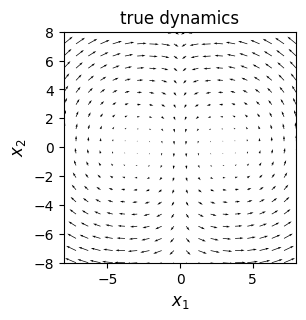

In [11]:
# visualize true dynamics flow field
plot_dynamics(generate_synthetic_dynamics, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: title={'center': 'true dynamics & latents'}, xlabel='$x_1$', ylabel='$x_2$'>

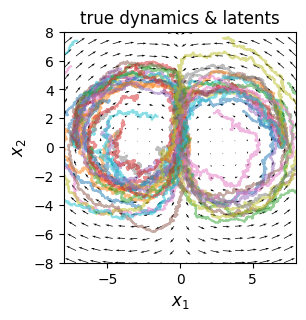

In [12]:
# plot true latent states on top of true dynamics
plot_dynamics_and_latents(generate_synthetic_dynamics, xs, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

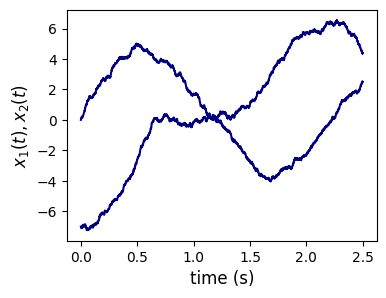

In [13]:
# plot observations for one trial
trial_idx = 0
plot_latents_over_time(t_max, xs[trial_idx], color='navy')

# Initialize the model

In [13]:
# initialize quadrature object and kernel
num_bases = 3
basis_set = lambda x: jnp.array([1., x[0], x[1]])
gh_quad = GaussHermiteQuadrature(latent_dim, n_quad=6)
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4
zs = initialize_zs(latent_dim, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)

# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = PoissonProcess(spikes, t_mask, dt_new, gh_quad, link='softplus')
# likelihood = Gaussian(firing_rate_data, t_mask)

In [14]:
# generate random seeds
key = jr.PRNGKey(1)
key_W, key_fp = jr.split(key, 2)

# intiialize number of linear states and kernel hyperparameters
num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, latent_dim), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

# initialize initial conditions for latents from Poisson LDS
# x0_init_params = jnp.stack([q.mean_continuous_states[i][0] for i in inds_to_select])

# initialize output parameters from Poisson LDS
# output_params_init = {'C': C_plds, 'd': d_plds}
output_params_init = {'C': C_init, 'd': d_init}

# initialize affine parameters
x0_init_params = None
# (C, d, R) = initialize_affine_params(latent_dim, firing_rate_data)
# output_params_init = {'C': C, 'd': d, 'R': R}

In [15]:
output_dim

50

# Fit model

In [17]:
key = jr.PRNGKey(0) # for minibatching; doesn't matter here, since we are using batch_size=n_trials

# set number of total vEM iters
n_iters = 25

# set a learning rate schedule
decay, forgetting_rate = 100, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate)

# fit model
# result = fit_variational_em(
#     key,
#     latent_dim,
#     dt,
#     fn,
#     likelihood,
#     trial_mask,
#     output_params_init,
#     kernel,
#     kernel_params_init,
#     inputs=None,
#     m0=x0_init_params,
#     mu0=x0_init_params,
#     n_iters=n_iters,
#     n_iters_e=15,
#     n_iters_m=150,
#     learning_rates=learning_rates,
#     batch_size=n_trials)

# collect results
# ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

result_dicts, elbos = fit_variational_em(
    key,
    latent_dim,
    dt,
    fn,
    likelihood,
    trial_mask,
    output_params_init,
    kernel,
    kernel_params_init,
    inputs=None,
    m0=x0_init_params,
    mu0=x0_init_params,
    n_iters=n_iters,
    n_iters_e=15,
    n_iters_m=150,
    learning_rates=learning_rates,
    batch_size=n_trials)

TypeError: mul got incompatible shapes for broadcasting: (125, 1), (2500, 50).

In [18]:
m0            = result_dicts[-1]['m0']           
S0            = result_dicts[-1]['S0']           
ms            = result_dicts[-1]['ms']           
Ss            = result_dicts[-1]['Ss']           
lmbdas        = result_dicts[-1]['lmbdas']       
Psis          = result_dicts[-1]['Psis']         
As            = result_dicts[-1]['As']           
bs            = result_dicts[-1]['bs']           
B             = result_dicts[-1]['B']            
q_u_mu        = result_dicts[-1]['q_u_mu']       
q_u_sigma     = result_dicts[-1]['q_u_sigma']    
mu0           = result_dicts[-1]['mu0']          
V0            = result_dicts[-1]['V0']           
output_params = result_dicts[-1]['output_params']
kernel_params = result_dicts[-1]['kernel_params']

IndexError: list index out of range

In [18]:
dt

0.001

# Plot results

In [19]:
# compute necessary rotation matrices
P = get_transformation_for_latents(C, output_params['C'])

# rotate inferred latents
ms_rot = (P @ ms[...,None]).squeeze(-1)
Ss_rot = P @ Ss @ P.T

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

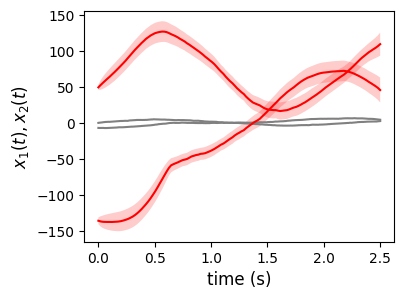

In [20]:
# plot true vs inferred latent states
trial_idx = 0
ax = plot_latents_over_time(t_max, xs[trial_idx], color='gray')
plot_latents_over_time(t_max, ms_rot[trial_idx], Ss_rot[trial_idx], color='red', ax=ax)

In [21]:
# visualize learned dynamics
# generate grid in true generative space
xlim = 4
n_grid = 15
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid),
    jnp.linspace(-xlim, xlim, n_grid)
)
# Xs_rot = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)

# # rotate grid to gpslds inferred space
# Xs = jnp.linalg.solve(P, Xs_rot.T).T
# Xs_grid = Xs.reshape(n_grid, n_grid, -1)

Xs = jnp.column_stack([X1.ravel(), X2.ravel()])

zs_lim, M_per_dim = 4, 4
zs = initialize_zs(latent_dim, zs_lim, M_per_dim)

basis_set = lambda x: jnp.array([1., x[0] ** 2, x[1] ** 2])
gh_quad = GaussHermiteQuadrature(latent_dim, n_quad=6)
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# generate mean of learned dynamics in gpslds space, then rotate back to true space
f_mean = get_posterior_f_mean(kernel.K, kernel_params, Xs, zs, q_u_mu)
f_mean_rot = (P @ f_mean[...,None]).squeeze(-1)

# compute posterior uncertainty
f_var = get_posterior_f_var(kernel.K, kernel_params, Xs, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

Text(0, 0.5, '$x_2$')

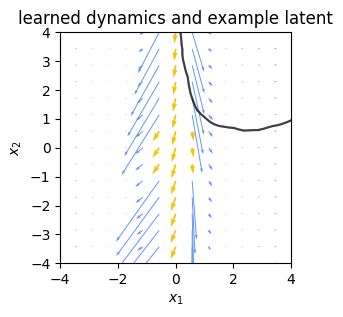

In [22]:
# plot learned dynamics colored by most likely state
trial_idx = 0

fig, ax = plt.subplots(figsize=(3, 3))
most_likely_state = get_most_likely_state(kernel.construct_partition, kernel_params, Xs)
colors = ["cornflowerblue", "#F1C509"]

for i in range(num_states):
    state_inds = (most_likely_state == i).astype(bool)
    # ax.quiver(Xs_rot[state_inds,0], Xs_rot[state_inds,1], f_mean_rot[state_inds,0], f_mean_rot[state_inds,1], color=colors[i])
    # ax.plot(ms_rot[trial_idx,:,0], ms_rot[trial_idx,:,1], 'k', alpha=0.5)

    ax.quiver(Xs[state_inds,0], Xs[state_inds,1], f_mean[state_inds,0], f_mean[state_inds,1], color=colors[i])
    ax.plot(ms[trial_idx,:,0], ms[trial_idx,:,1], 'k', alpha=0.5)

ax.set_aspect(1.)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title("learned dynamics and example latent")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [23]:
# compute posterior variance on a finer grid
# generate grid in true generative space
xlim = 8
n_grid_fine = 40
X1_fine, X2_fine = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid_fine),
    jnp.linspace(-xlim, xlim, n_grid_fine)
)
Xs_rot_fine = jnp.column_stack([X1_fine.ravel(), X2_fine.ravel()]) # (N**2, 2)
Xs_rot_grid_fine = Xs_rot_fine.reshape(n_grid_fine, n_grid_fine, -1)

# rotate to gpslds inferred space
Xs_fine = jnp.linalg.solve(P, Xs_rot_fine.T).T
Xs_grid_fine = Xs_fine.reshape(n_grid_fine, n_grid_fine, -1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs_fine, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

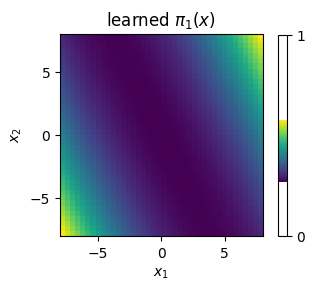

In [24]:
# plot learned partition function
learned_partition = get_learned_partition(kernel.construct_partition, kernel_params, Xs_fine)
learned_partition_grid = learned_partition.reshape(n_grid_fine, n_grid_fine, -1)

fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(learned_partition_grid[:,:,0], origin='lower', extent=[-xlim, xlim, -xlim, xlim])
ax.set_aspect(1.)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_title(r"learned $\pi_1(x)$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1])

NameError: name 'Xs_rot' is not defined

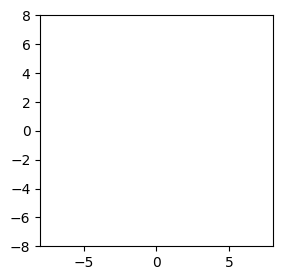

In [25]:
# plot learned dynamics with posterior uncertainty
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(3, 3))

levels = 10**(jnp.linspace(-2.5, 1, 15))
contour = ax.contourf(X1_fine, X2_fine, f_det_rot.reshape(n_grid_fine, n_grid_fine), levels=levels, alpha=0.5, locator=ticker.LogLocator(), cmap='Purples')
ax.quiver(Xs_rot[:,0], Xs_rot[:,1], f_mean_rot[:,0], f_mean_rot[:,1], color='black', alpha=0.3)

ax.set_aspect(1)
ax.set_title("posterior variance", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.locator = ticker.LogLocator(10)
cbar.set_ticks([1e-2, 1e1])